In [1]:
from deeprobust.graph.data import Dataset
from deeprobust.graph.defense import GCN
from deeprobust.graph.targeted_attack import FGA, IGAttack
from deeprobust.graph.global_attack import MinMax
from deeprobust.graph.utils import preprocess, normalize_adj_tensor
import torch.optim as optim
import torch.nn.functional as F
from utils import *
from torch_geometric.utils import dense_to_sparse
from torch_geometric.nn.models import GAT

In [2]:
#If missing imports, clone https://github.com/ChandlerBang/pytorch-gnn-meta-attack?tab=readme-ov-file

In [3]:
import sys
import argparse

sys.argv = [
    'notebook',
    '--seed', '15',
    '--epochs', '100',
    '--lr', '0.01',
    '--hidden', '16',
]

# Now use argparse as usual
parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=15, help='Random seed.')
parser.add_argument('--epochs', type=int, default=100, help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.01, help='Initial learning rate.')
parser.add_argument('--hidden', type=int, default=16, help='Number of hidden units.')

args = parser.parse_args()
device = 'cpu'
print(args)

Namespace(seed=15, epochs=100, lr=0.01, hidden=16)


In [4]:
data = Dataset(root='/tmp/', name='cora')
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

Loading cora dataset...
Selecting 1 largest connected components


In [5]:
surrogate = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, dropout=0, with_relu=False, with_bias=False, device='cpu').to('cpu')
surrogate.fit(features, adj, labels, idx_train, idx_val, patience=30)

/usr/local/lib/python3.10/site-packages/deeprobust/graph/utils.py:356: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:607.)
  return torch.sparse.FloatTensor(sparseconcat.t(),sparsedata,torch.Size(sparse_mx.shape))


In [6]:
target_node = 0
model = IGAttack(surrogate, nnodes=adj.shape[0], attack_structure=True, attack_features=True, device='cpu').to('cpu')
model.attack(features, adj, labels, idx_train, target_node, n_perturbations=100, steps=10)
modified_adj = model.modified_adj
modified_features = model.modified_features

100%|███████████████████████████████████████| 1433/1433 [05:20<00:00,  4.47it/s]


In [7]:
# todo: fix modularity

In [8]:
def test_gcn(adj, features):
    adj = normalize_adj_tensor(adj)
    gcn = GCN(nfeat=features.shape[1],
              nhid=args.hidden,
              nclass=labels.max().item() + 1,
              dropout=0.5,
              device='cpu')

    if device != 'cpu':
        gcn = gcn.to(device)

    optimizer = optim.Adam(gcn.parameters(),
                           lr=args.lr, weight_decay=5e-4)

    gcn.train()

    for epoch in range(args.epochs):
        optimizer.zero_grad()
        output = gcn(features, adj)
        loss_train = F.nll_loss(output[idx_train], labels[idx_train])
        acc_train = accuracy(output[idx_train], labels[idx_train])
        loss_train.backward()
        optimizer.step()

    gcn.eval()
    output = gcn(features, adj)

    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    #print("Test set results:",
    #       "loss= {:.4f}".format(loss_test.item()),
    #       "accuracy= {:.4f}".format(acc_test.item()))

    return acc_test.item()

In [9]:
def test_gat(adj, features):
    adj = normalize_adj_tensor(adj)
    edge_index, _ = dense_to_sparse(adj)
    device='cpu'
    edge_index = edge_index.to(device)

    gatv1 = GAT(
        in_channels=features.shape[1],
        num_layers=1,
        hidden_channels=args.hidden,
        out_channels=labels.max().item() + 1,
        dropout=0.5,
        heads=8
    ).to(device)

    optimizer = optim.Adam(gatv1.parameters(), lr=args.lr, weight_decay=5e-4)

    gatv1.train()

    for epoch in range(args.epochs):
        optimizer.zero_grad()
        output = F.log_softmax(gatv1(features, edge_index), dim=1)

        loss_train = F.nll_loss(output[idx_train], labels[idx_train])
        acc_train = accuracy(output[idx_train], labels[idx_train])
        loss_train.backward()
        torch.nn.utils.clip_grad_norm_(gatv1.parameters(), max_norm=1.0)
        optimizer.step()

    gatv1.eval()
    output = F.log_softmax(gatv1(features, edge_index), dim=1)

    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    #print("Test set results:",
    #       "loss= {:.4f}".format(loss_test.item()),
    #       "accuracy= {:.4f}".format(acc_test.item()))

    return acc_test.item()

In [10]:
def test_gatv2(adj, features):
    adj = normalize_adj_tensor(adj)
    edge_index, _ = dense_to_sparse(adj)
    device='cpu'
    edge_index = edge_index.to(device)

    gatv2 = GAT(
        v2=True,
        in_channels=features.shape[1],
        num_layers=1,
        hidden_channels=args.hidden,
        out_channels=labels.max().item() + 1,
        dropout=0.5,
        heads=8
    ).to(device)

    optimizer = optim.Adam(gatv2.parameters(), lr=args.lr, weight_decay=5e-4)

    gatv2.train()

    for epoch in range(args.epochs):
        optimizer.zero_grad()
        output = F.log_softmax(gatv2(features, edge_index), dim=1)

        loss_train = F.nll_loss(output[idx_train], labels[idx_train])
        acc_train = accuracy(output[idx_train], labels[idx_train])
        loss_train.backward()
        torch.nn.utils.clip_grad_norm_(gatv2.parameters(), max_norm=1.0)
        optimizer.step()

    gatv2.eval()
    output = F.log_softmax(gatv2(features, edge_index), dim=1)

    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    #print("Test set results:",
    #       "loss= {:.4f}".format(loss_test.item()),
    #       "accuracy= {:.4f}".format(acc_test.item()))

    return acc_test.item()


In [11]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

def test_and_visualize(adj, modified_adj, features, modified_features, test_function, name):
    runs = 25
    clean_acc = []
    attacked_acc = []
   
    print(f'=== testing {name} on original(clean) graph ===')
    for i in range(runs):
        clean_acc.append(test_function(adj, features))

    print(f'=== testing {name} on attacked graph ===')
    for i in range(runs):
        attacked_acc.append(test_function(modified_adj, modified_features))

    data = {
      'Accuracy Type': ['Acc. Clean'] * len(clean_acc) + ['Acc. Perturbed'] * len(attacked_acc),
      'Accuracy': clean_acc + attacked_acc
    }
    
    df = pd.DataFrame(data)

    plt.figure(figsize=(6, 6))
    sns.boxplot(x='Accuracy Type', y='Accuracy', data=df)

    plt.title("Accuracy before/after IG attack, {}".format(name))
    plt.show()

In [12]:
adj, features, labels = preprocess(adj, features, labels, preprocess_adj=False) 
modified_adj, modified_features, labels = preprocess(modified_adj, modified_features, labels, preprocess_adj=False)

=== testing GCN on original(clean) graph ===
=== testing GCN on attacked graph ===


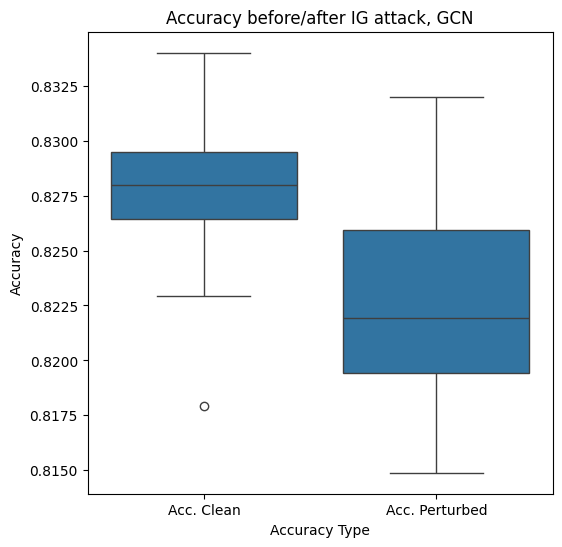

In [13]:
test_and_visualize(adj, modified_adj, features, modified_features, test_gcn, "GCN")

=== testing GAT on original(clean) graph ===
=== testing GAT on attacked graph ===


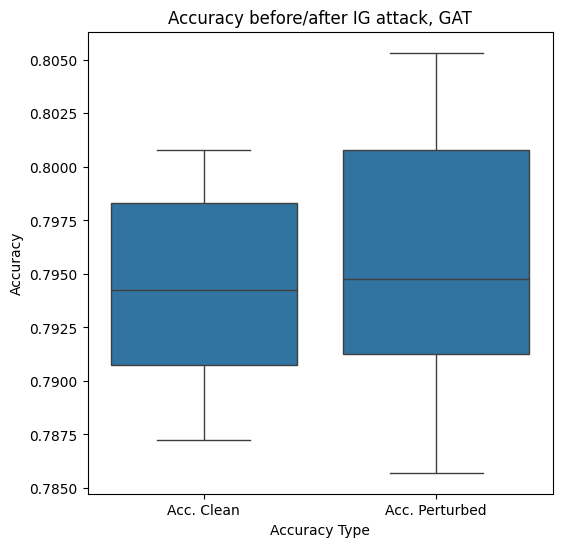

In [14]:
test_and_visualize(adj, modified_adj, features, modified_features, test_gat, "GAT")

=== testing GATv2 on original(clean) graph ===
=== testing GATv2 on attacked graph ===


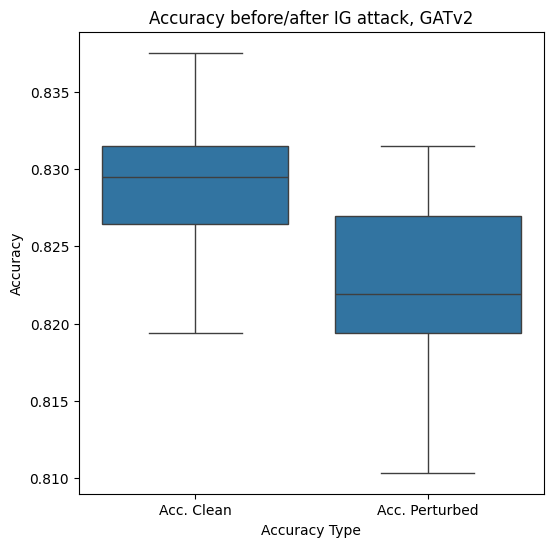

In [15]:
test_and_visualize(adj, modified_adj, features, modified_features, test_gcn, "GATv2")